# Scikit-Learn binary classification model training on local notebook. 
## Plus Azure ML Dataset converted to Pandas DataFrames.
_**The code is plain vanilla Scikit-Learn training/creation of a Binary classification model.**_

_**Azure ML is only used to gather original data from an AML Dataset.**_

_**This notebook can run on a local PC or on any Azure ML Compute Instance or Azure ML VM.**_

This code is the baseline for the next labs/notebooks in the Workshop moving to AML remote compute, etc.

### Import libraries to use in notebook

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from azureml.core import Workspace, Dataset
from azureml.core import Environment

# Check versions
import azureml.core
import sklearn
import joblib
import pandas

print("Azure SDK version:", azureml.core.VERSION)
print('scikit-learn version is {}.'.format(sklearn.__version__))
print('joblib version is {}.'.format(joblib.__version__))
print('pandas version is {}.'.format(pandas.__version__))

Azure SDK version: 1.16.0
scikit-learn version is 0.22.2.post1.
joblib version is 0.14.1.
pandas version is 0.25.3.


### Create Workspace to load Tabular Datasets and log info from local training into AML

In [2]:
# Connect to an existing Azure ML Workshop in order to use Azure ML Datasets and Runs Logging into AML

ws = Workspace.from_config()

### Load the IBM employee attrition data created before

Note: as you are now accessing the workspace, the Notebook needs to be authenticated for access through device authentication. Hence, you will be prompted with a device login like so: 

    Performing interactive authentication. Please follow the instructions on the terminal.
    To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code ARQPFR4B4 to authenticate.
    
Please follow these instructions in a new browser tab.

In [3]:
# get the IBM employee attrition dataset from the workspace
attritionData = ws.datasets['IBM-Employee-Attrition'].to_pandas_dataframe()
attritionData.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Clean up the initial dataset

In [4]:
# Dropping Employee Count and Over18 as all values are 1 and hence attrition is independent of this feature
attritionData = attritionData.drop(['EmployeeCount'], axis=1)
attritionData = attritionData.drop(['Over18'], axis=1)

# Dropping Employee Number since it is merely an identifier
attritionData = attritionData.drop(['EmployeeNumber'], axis=1)

# Since all values are 80 let's drop also StandardHours
attritionData = attritionData.drop(['StandardHours'], axis=1)

target = attritionData["Attrition"]

attritionXData = attritionData.drop(['Attrition'], axis=1)

## Split in Train and Test datasets (DataFrames)

In [5]:
# Split data into train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(attritionXData, 
                                                    target, 
                                                    test_size = 0.2,
                                                    random_state=0,
                                                    stratify=target)

## Transform data

In [6]:
# Collect the categorical and numerical column names in separate lists
categorical = []
for col, value in attritionXData.iteritems():
    if value.dtype == 'object':
        categorical.append(col)
        
numerical = attritionXData.columns.difference(categorical)

### Transform raw features
We can explain raw features by either using a sklearn.compose.ColumnTransformer or a list of fitted transformer tuples. The cell below uses sklearn.compose.ColumnTransformer. In case you want to run the example with the list of fitted transformer tuples, comment the cell below and uncomment the cell that follows after.

## Create data processing pipelines (Scikit-Learn pipelines)
NOTE: This code uses Scikit-Learn pipelines. Not related to AML Pipelines. Different concept. 

In [7]:
from sklearn.compose import ColumnTransformer

# We create the transformations pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transforms_pipeline = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

## Add classifier algorithm (SVC: Support Vector Classifier) to the pipeline

In [8]:
# Append classifier to Scikit-Learn transformations pipeline.
# Now we have a full Scikit-Learn prediction pipeline.
model_pipeline = Pipeline(steps=[('preprocessor', transforms_pipeline),
                      ('classifier', SVC(kernel='linear', C = 1.0, probability=True))]) 

## Create AML Experiment, run and log just for logging info while training locally in Notebook

Let's start an interactive logging session using *start_logging()*. It'll create also an interactive run in the specified experiment. Any metrics logged during the session are added to the run record in the experiment. The method *run.complete()* ends the sessions and marks the run as completed.
You can find other logging examples [here](https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/track-and-monitor-experiments/logging-api/logging-api.ipynb).

In [61]:
from azureml.core import Experiment

# Get an experiment object from AML
experiment = Experiment(workspace=ws, name="aml-wrkshp-local-train-notebook-log")

# Create an interactive run object in the experiment
run =  experiment.start_logging()

# Log the algorithm parameter C to the run
run.log('C', 1.0)

## Train the SVM (Support Vector Machine) Classifier Model

In [62]:
model = model_pipeline.fit(x_train, y_train)

## Make Predictions and calculate Accuracy metric

In [63]:
x_test.describe()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,...,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,36.489796,788.336735,8.812925,2.925170,2.690476,65.500000,2.727891,2.054422,2.863946,6352.948980,...,3.149660,2.670068,0.809524,10.632653,2.863946,2.727891,6.360544,4.112245,1.955782,3.894558
std,8.832818,406.133083,7.938482,0.957018,1.059386,20.292528,0.711273,1.027156,1.074936,4456.963665,...,0.357346,1.091382,0.837136,6.973946,1.348185,0.757739,5.206252,3.533987,2.891924,3.367041
min,18.000000,107.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1052.000000,...,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,452.250000,2.000000,2.000000,2.000000,47.250000,2.000000,1.000000,2.000000,2986.250000,...,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000
50%,35.000000,811.500000,7.000000,3.000000,3.000000,65.500000,3.000000,2.000000,3.000000,4966.000000,...,3.000000,3.000000,1.000000,9.500000,3.000000,3.000000,5.000000,3.000000,1.000000,2.000000
75%,42.000000,1135.000000,12.000000,4.000000,4.000000,83.750000,3.000000,2.000000,4.000000,7748.250000,...,3.000000,4.000000,1.000000,14.000000,3.000000,3.000000,9.000000,7.000000,2.000000,7.000000
max,60.000000,1496.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19926.000000,...,4.000000,4.000000,3.000000,36.000000,6.000000,4.000000,29.000000,16.000000,15.000000,13.000000


In [64]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score


# Make Multiple Predictions
y_predictions = model.predict(x_test)

accuracy = accuracy_score(y_test, y_predictions)
rocauc = roc_auc_score(y_test, y_predictions)
average_precision = average_precision_score(y_test, y_predictions)

model_details_df = pd.DataFrame([accuracy, rocauc, average_precision],
                                columns = ['SVM'],
                                index=['Accuracy','ROC-AUC','Avg Precision'])

model_details_df


,SVM
Accuracy,0.880952
ROC-AUC,0.653502
Avg Precision,0.374801


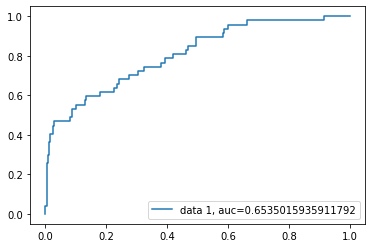

In [65]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_pred_proba = model.predict_proba(x_test)[::,1]

fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

plt.plot(fpr,tpr,label="data 1, auc="+str(rocauc))
plt.legend(loc=4)
run.log_image("ROC Curve", plot=plt)
#plt.show()

## Log metric and model into the AML run definition
### Note that training is local, we just use the run definition to log information about the run/training 

In [66]:
# Current folder, where the pkl file will be created
import os
os.getcwd()

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/azureml-ci/code/azureml-workshop-2019/2-training-inference/2.1-aml-training-and-hyperdrive/1-scikit-learn-local-training-on-notebook-plus-aml-ds-and-log'

In [67]:
# Output the Mean Squared Error to the notebook and to the run
 
run.log('Accuracy', accuracy)
run.log('ROC-AUC', rocauc)
run.log('Avg Precision', average_precision)


# Save the model to the outputs directory for capture
model_file_name = 'outputs/model.pkl'

# Allow local file overwriting
model_file_obj = open(model_file_name, 'wb')

# Persiste the model into the pkl file
joblib.dump(value = model, filename = model_file_obj)

In [68]:
# Any file into the ./output folder will be automatically uploaded into the run artifacts 
run.complete()

In [ ]:
# # In case of duplicate artifact errors
# run.cancel() # Even if an exception is thrown, the run will be canceled anyway

### Check the experiment run and its logged info in Azure ML Workspace
Now, you should go to your AML Workspace and check the information logged for this run, such as the accuracy, hyper-parameters and any other info you logged for the experiment run.

## Confusion Matrix

You can easly get the values of the confusion matrix associated to the model in the following way:

Confusion matrix, without normalization
[[244   3]
 [ 32  15]]
Normalized confusion matrix
[[0.98785425 0.01214575]
 [0.68085106 0.31914894]]


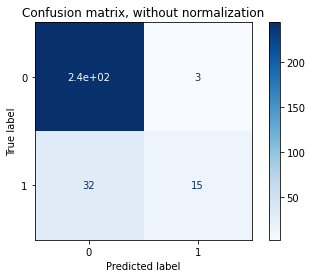

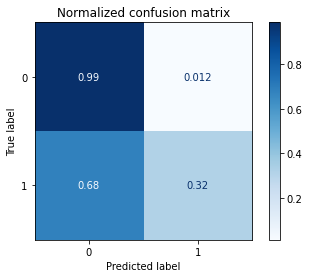

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

class_names = y_train.unique()

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [82]:
# Index of the instance you want to use as input for a prediction
instance_num = 6 # The seventh instance from the beginning (0-based)

# Get the prediction for the upon defined index
prediction_values = model.predict(x_test)
prediction_probs = model.predict_proba(x_test)

print("Classes:")
print(model.classes_)

print("Prediction label for instance", instance_num, ":")
print(prediction_values[instance_num])

print("Prediction probabilities for instance", instance_num, ":")
print(prediction_probs[instance_num])

x_test.iloc[instance_num]

Classes:
[0 1]
Prediction label for instance 6 :
1
Prediction probabilities for instance 6 :
[0.52713004 0.47286996]


Age                                           47
BusinessTravel                     Travel_Rarely
DailyRate                                   1454
Department                                 Sales
DistanceFromHome                               2
Education                                      4
EducationField                     Life Sciences
EnvironmentSatisfaction                        4
Gender                                    Female
HourlyRate                                    65
JobInvolvement                                 2
JobLevel                                       1
JobRole                     Sales Representative
JobSatisfaction                                4
MaritalStatus                             Single
MonthlyIncome                               3294
MonthlyRate                                13137
NumCompaniesWorked                             1
OverTime                                       1
PercentSalaryHike                             18
PerformanceRating   

In [93]:
prediction_probs[0:7]

array([[0.97776338, 0.02223662],
       [0.91713267, 0.08286733],
       [0.60181035, 0.39818965],
       [0.85908046, 0.14091954],
       [0.95513197, 0.04486803],
       [0.85916381, 0.14083619],
       [0.52713004, 0.47286996]])

In [94]:
prediction_values[0:7]

array([0, 0, 0, 0, 0, 0, 1])

I expected the default used threshold was 0.5. If so the 7th predicted label would be 0.

Since it's 1, I'm looking for the possible used threhsold:

In [128]:
for tr in np.arange(0.0, 1.0, 0.01):
    if all( np.where(prediction_probs[:,1] > tr, True, False) == prediction_values ):
        print('Possible used threshold is:', tr)

Possible used threshold is: 0.42
Possible used threshold is: 0.43
Possible used threshold is: 0.44
